In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd 
from glob import glob
from os.path import join 
import os, sys
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

sys.path.insert(1, '../MLpipelines/')
from plotResults import *

### 1. Visualization

In [7]:
models_dir = sorted(glob("../MLpipelines/results/newlbls-fu3-espad-fu3-19a-binge-*/*/"))[-1]
models_dir

'../MLpipelines/results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730/'

#### 1.1 probability distributions

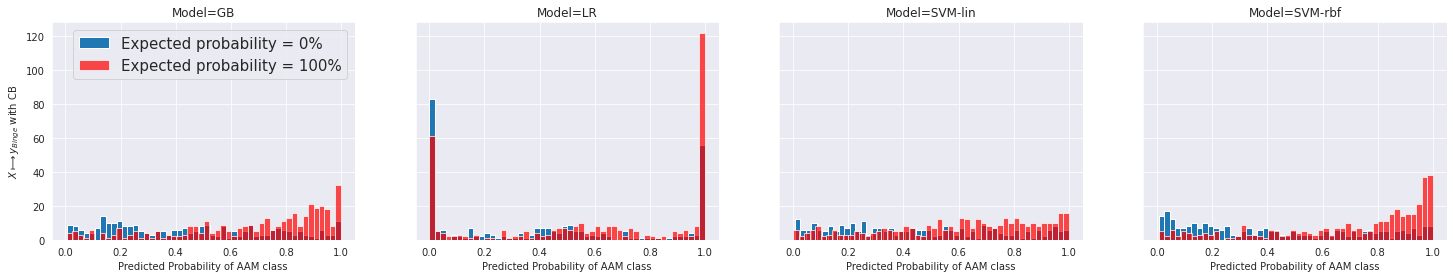

In [9]:
df = pd.read_csv(models_dir+"/run.csv")

grp_order = ["io", "technique", "model"]
groups = df.groupby(grp_order)   
n_models = len(df["model"].unique())
n_rows = round(len(groups)/n_models)
fig, axes = plt.subplots(n_rows, n_models, 
                         sharex=True, sharey=True,
                         figsize=(25, n_models*n_rows))
axes = np.ravel(axes)
        
for i, (g, dfi) in enumerate(groups):
    ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
    assert ids_all.shape[0] == np.unique(ids_all).shape[0]
    probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
    y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
    assert probs_all.shape[0] == y_all.shape[0]

    prediction=probs_all[:,1]
    ax = axes[i]
    ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
    ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
    ax.set_xlabel('Predicted Probability of AAM class')
    if i%n_models == 0:
        ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
    if i == 0:
        ax.legend(fontsize=15)
    ax.set_title("Model={}".format(g[-1]))
    
plt.show() 

### 1.2 SHAP values
 1. what is the best/fastest estimator for my 4 models?
 2. how to save and load SHAP values?
 3. What to visualize?

In [10]:
import shap

In [22]:
# load all trained models
from joblib import load 

models = {}
model_names = list(set([f.split("_")[0] for f in os.listdir(models_dir) if f.split(".")[-1]=="model"]))
for model_name in model_names:
    models.update({model_name: [load(f) for f in glob(models_dir+f"/{model_name}_*.model")]})

models['SVM-rbf'][0]

Pipeline(steps=[('varth', VarianceThreshold()), ('scale', StandardScaler()),
                ('conf_corr_cb',
                 CounterBalance(oversample=True, random_state=15)),
                ('model_SVM-rbf', SVC(gamma='auto', probability=True))])

In [23]:
# load the training data
import h5py

h5_dir = "/ritter/share/data/IMAGEN/h5files/newholdout-fu3-espad-fu3-19a-binge-n102.h5"
data = h5py.File(h5_dir, 'r')
data.keys(), data.attrs.keys()

(<KeysViewHDF5 ['Binge', 'X', 'i', 'sex', 'site']>,
 <KeysViewHDF5 ['X_col_names', 'confs', 'labels']>)

In [24]:
X = data['X'][()]
y = data[data.attrs['labels'][0]][()]
X_col_names = data.attrs['X_col_names'][()]

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

X.shape, y.shape, len(X_col_names)

((102, 723), (102,), 723)

In [27]:
shap_values_stored = {}

for model_name in models:
    print
    if ( model_name.upper() not in ["SVM-RBF", "GB"]):
        print("skipping model {}".format(model_name))
        continue
    
    print("generating SHAP plots for model = {} ..".format(model_name))
    for i, model in enumerate(models[model_name]):
        if i>2:
            print("skipping model {} {} as it is taking too long".format(model_name, i))
            continue
        print(model)
        explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"])
        shap_values = explainer(X)
        shap_values_stored.update({model_name+str(i): shap_values})
        
len(shap_values_stored)

skipping model SVM-lin
generating SHAP plots for model = GB ..
Pipeline(steps=[('varth', VarianceThreshold()), ('scale', StandardScaler()),
                ('conf_corr_cb',
                 CounterBalance(oversample=True, random_state=27)),
                ('model_GB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=48, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
      

Permutation explainer:  17%|█▋        | 17/102 [12:33<1:05:36, 46.31s/it]

KeyboardInterrupt: 

In [ ]:
for model_name, shap_values in shap_values_stored.items():
    shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="bar")
    plt.title(model_name)
    plt.savefig("figures/{}_bar.pdf".format(model_name))
    shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="dot")
    plt.title(model_name)
    plt.savefig("figures/{}_swarm.pdf".format(model_name))
    shap.group_difference_plot(shap_values.values, group_mask=data['sex'][()].astype(bool), 
                       feature_names=X_col_names, max_display=10)
    plt.title(model_name)
    plt.savefig("figures/{}_bar-sexdiff.pdf".format(model_name))


## playground

In [12]:
model = models['GB'][0]

In [26]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"])

In [ ]:
shap_values = explainer(X)

Permutation explainer:  28%|██▊       | 186/668 [2:02:02<5:22:32, 40.15s/it]

In [ ]:
# for i, sub in enumerate(shap_values): #.values.shape
#     print("sub idx={}".format(i))
#     for j, feature in enumerate(sub):
#         print("feature idx={}".format(j))
#         display(type(feature), feature)
        

# shap_values[...,0]

In [53]:
# clustering = shap.utils.hclust(X, y)

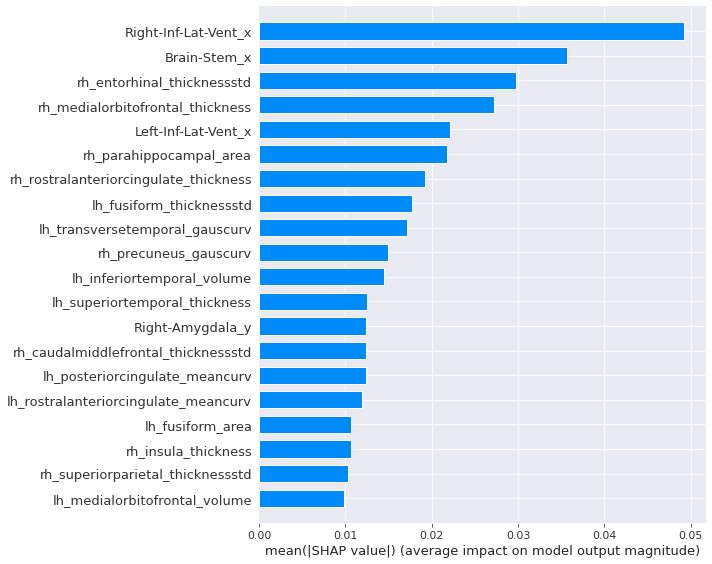

In [64]:
shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="bar")

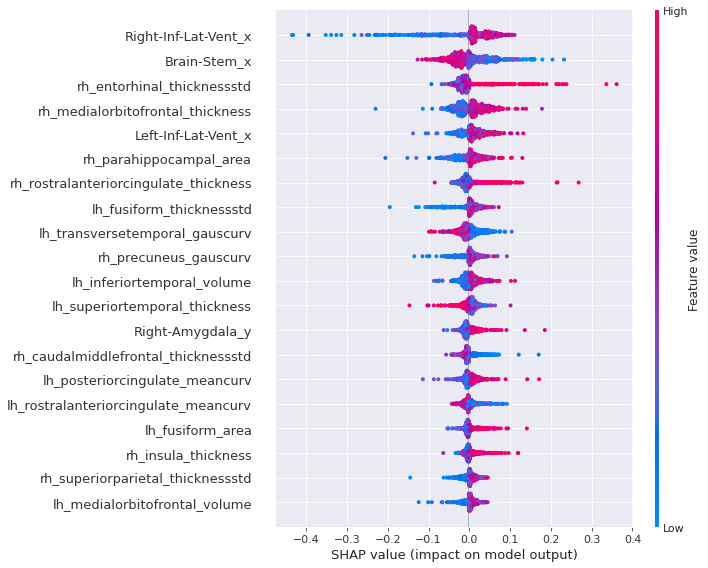

In [51]:
shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="dot")

FixedFormatter should only be used together with FixedLocator


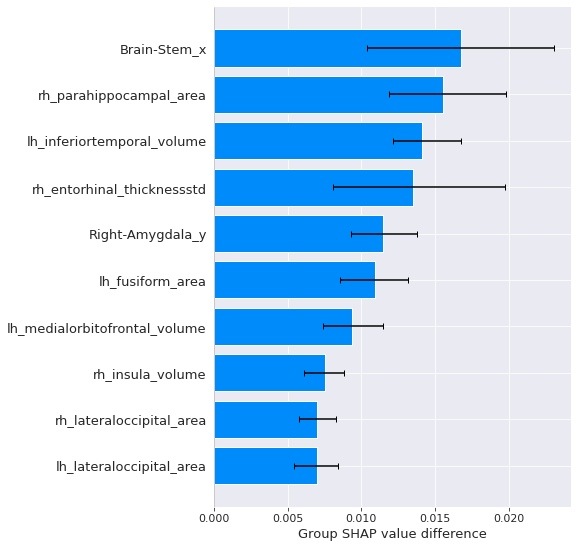

In [63]:
shap.group_difference_plot(shap_values.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)

In [62]:
# individual features
# shap.embedding_plot(396, shap_values.values, feature_names=X_col_names)
# shap.dependence_plot(ind, shap_values=None, features=None, feature_names=None, display_features=None)
# individual subject predictions
#  shap.waterfall_plot(shap_values, max_display=10, show=True)

In [77]:
model = models['LR'][0]
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"], feature_names=X_col_names)

In [ ]:
shap_values_lr = explainer(X)

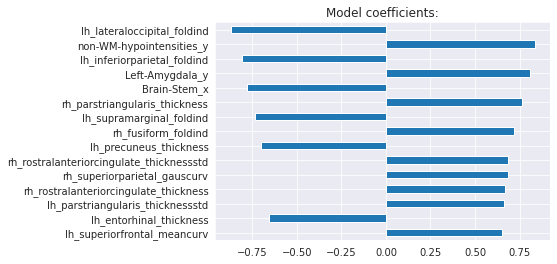

In [98]:
# plot the coefs of Logistic Regression
coefs = {}

for i in range(model['model_LR'].coef_.shape[-1]):
    coefs.update({X_col_names[i] : model['model_LR'].coef_[0,i].round(4)})
pd.Series(coefs).sort_values(key=np.abs)[-15:].plot.barh(title="Model coefficients:")
plt.show()

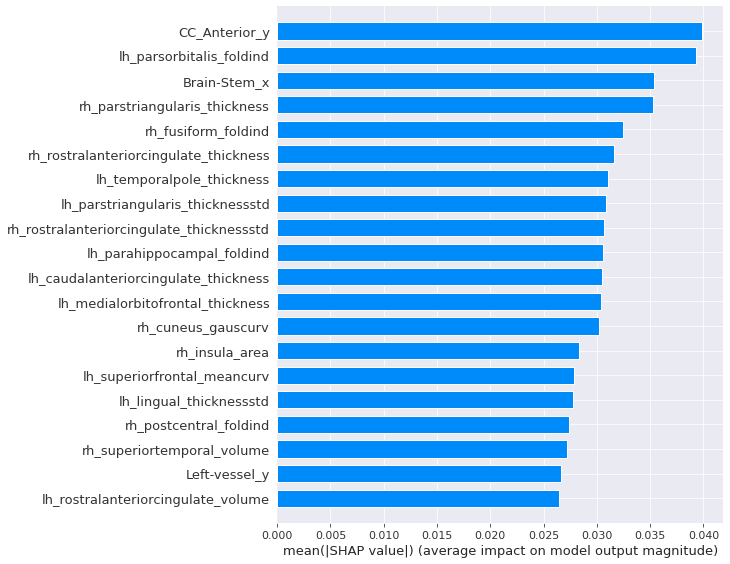

In [71]:
shap.summary_plot(shap_values_lr, features=X, feature_names=X_col_names, plot_type="bar")

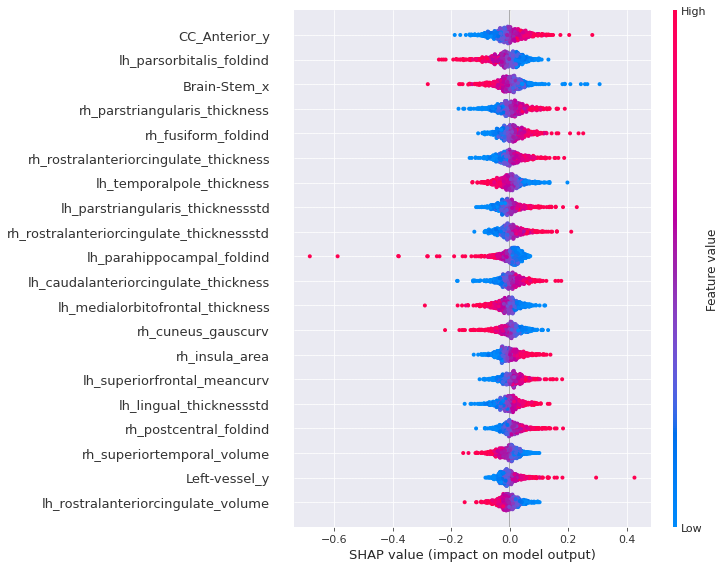

In [72]:
shap.summary_plot(shap_values_lr, features=X, feature_names=X_col_names, plot_type="dot")

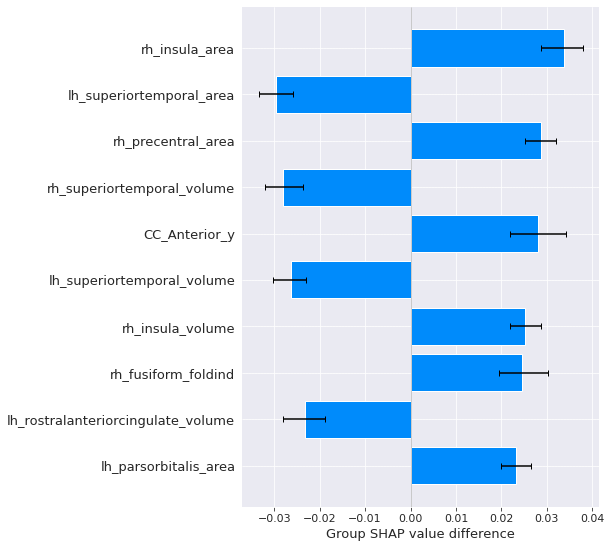

In [74]:
shap.group_difference_plot(shap_values_lr.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)

In [99]:
model = models['SVM-rbf'][0]
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"], feature_names=X_col_names)

In [ ]:
shap_values_svmrbf = explainer(X)

Permutation explainer:  13%|█▎        | 85/668 [8:26:29<58:12:32, 359.44s/it]

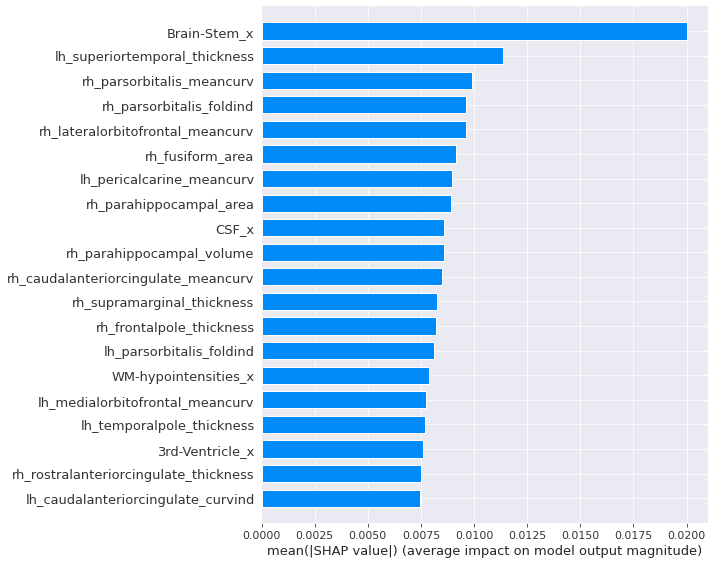

In [105]:
shap.summary_plot(shap_values_svmrbf, features=X, feature_names=X_col_names, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values_svmrbf, features=X, feature_names=X_col_names, plot_type="dot")

In [ ]:
shap.group_difference_plot(shap_values_svmrbf.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)

---

In [ ]:
model = models['SVM-lin'][0]
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"], feature_names=X_col_names)
shap_values_svmlin = explainer(X)

In [ ]:
shap.summary_plot(shap_values_svmlin, features=X, feature_names=X_col_names, plot_type="bar")
shap.summary_plot(shap_values_svmlin, features=X, feature_names=X_col_names, plot_type="dot")
shap.group_difference_plot(shap_values_svmlin.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)